<h1>Содержание<span class="tocSkip"></span></h1>
<div class="toc"><ul class="toc-item"><li><span><a href="#Подготовка" data-toc-modified-id="Подготовка-1"><span class="toc-item-num">1&nbsp;&nbsp;</span>Подготовка</a></span></li><li><span><a href="#Модель-без-BERT" data-toc-modified-id="Модель-без-BERT-2"><span class="toc-item-num">2&nbsp;&nbsp;</span>Модель без BERT</a></span></li><li><span><a href="#Модель-c-BERT" data-toc-modified-id="Модель-c-BERT-3"><span class="toc-item-num">3&nbsp;&nbsp;</span>Модель c BERT</a></span></li><li><span><a href="#Выводы" data-toc-modified-id="Выводы-4"><span class="toc-item-num">4&nbsp;&nbsp;</span>Выводы</a></span></li></ul></div>

# Проект для «Викишоп» с BERT

Интернет-магазин «Викишоп» запускает новый сервис. Теперь пользователи могут редактировать и дополнять описания товаров, как в вики-сообществах. То есть клиенты предлагают свои правки и комментируют изменения других. Магазину нужен инструмент, который будет искать токсичные комментарии и отправлять их на модерацию. 

Обучите модель классифицировать комментарии на позитивные и негативные. В вашем распоряжении набор данных с разметкой о токсичности правок.


**Ход работы:**

1. Загрузка и подготовка данных.
2. Обучение моделей. 
3. Выводы.


**Описание данных**

Данные находятся в файле `toxic_comments.csv`. Столбец *text* в нём содержит текст комментария, а *toxic* — целевой признак.

## Подготовка

In [1]:
!pip install -q scikit-learn==1.5.0
!pip install --upgrade matplotlib seaborn -q
!pip install torch -q
!pip install transformers -q
!pip install catboost -q

In [2]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.model_selection import train_test_split
from IPython.display import Markdown, display
from sklearn.pipeline import Pipeline
from sklearn.model_selection import GridSearchCV
from sklearn.metrics import f1_score
from sklearn.linear_model import LogisticRegression
from sklearn.svm import SVC
from sklearn.ensemble import RandomForestClassifier
import time
from datetime import datetime
from tqdm import notebook
import re
import nltk
from nltk.stem import WordNetLemmatizer
from nltk.corpus import stopwords as nltk_stopwords
from nltk.corpus import wordnet
from sklearn.feature_extraction.text import TfidfVectorizer 
import torch
import transformers
from catboost import CatBoostClassifier
sns.set_theme(style="whitegrid")
pd.set_option('display.max_colwidth', -1)
RANDOM_STATE = 42

C:\Users\paulv\AppData\Local\Temp\ipykernel_7128\1052823254.py:26: FutureWarning: Passing a negative integer is deprecated in version 1.0 and will not be supported in future version. Instead, use None to not limit the column width.
  pd.set_option('display.max_colwidth', -1)


In [3]:
nltk.download('wordnet')
nltk.download('stopwords')
nltk.download('averaged_perceptron_tagger')
nltk.download('punkt')
notebook.tqdm.pandas()

[nltk_data] Downloading package wordnet to
[nltk_data]     C:\Users\paulv\AppData\Roaming\nltk_data...
[nltk_data]   Package wordnet is already up-to-date!
[nltk_data] Downloading package stopwords to
[nltk_data]     C:\Users\paulv\AppData\Roaming\nltk_data...
[nltk_data]   Package stopwords is already up-to-date!
[nltk_data] Downloading package averaged_perceptron_tagger to
[nltk_data]     C:\Users\paulv\AppData\Roaming\nltk_data...
[nltk_data]   Package averaged_perceptron_tagger is already up-to-
[nltk_data]       date!
[nltk_data] Downloading package punkt to
[nltk_data]     C:\Users\paulv\AppData\Roaming\nltk_data...
[nltk_data]   Package punkt is already up-to-date!


In [4]:
try:
    toxic_comments = pd.read_csv('/datasets/toxic_comments.csv', sep=",", index_col=[0], parse_dates=[0])
    print('Код выполняется на платформе')
except FileNotFoundError:
    toxic_comments = pd.read_csv('datasets/toxic_comments.csv', sep=",", index_col=[0], parse_dates=[0])
    print('Код выполняется локально')

Код выполняется локально


In [5]:
toxic_comments.head(5)

,text,toxic
0,"Explanation\nWhy the edits made under my username Hardcore Metallica Fan were reverted? They weren't vandalisms, just closure on some GAs after I voted at New York Dolls FAC. And please don't remove the template from the talk page since I'm retired now.89.205.38.27",0
1,"D'aww! He matches this background colour I'm seemingly stuck with. Thanks. (talk) 21:51, January 11, 2016 (UTC)",0
2,"Hey man, I'm really not trying to edit war. It's just that this guy is constantly removing relevant information and talking to me through edits instead of my talk page. He seems to care more about the formatting than the actual info.",0
3,"""\nMore\nI can't make any real suggestions on improvement - I wondered if the section statistics should be later on, or a subsection of """"types of accidents"""" -I think the references may need tidying so that they are all in the exact same format ie date format etc. I can do that later on, if no-one else does first - if you have any preferences for formatting style on references or want to do it yourself please let me know.\n\nThere appears to be a backlog on articles for review so I guess there may be a delay until a reviewer turns up. It's listed in the relevant form eg Wikipedia:Good_article_nominations#Transport """,0
4,"You, sir, are my hero. Any chance you remember what page that's on?",0


In [6]:
toxic_comments.shape

(159292, 2)

In [7]:
toxic_comments.duplicated().sum()

0

In [8]:
toxic_comments.toxic.value_counts()

0    143106
1    16186 
Name: toxic, dtype: int64

In [9]:
lemmatizer = WordNetLemmatizer()

In [10]:
def get_wordnet_pos(tag):
    if tag.startswith('J'):
        return wordnet.ADJ
    elif tag.startswith('V'):
        return wordnet.VERB
    elif tag.startswith('N'):
        return wordnet.NOUN
    elif tag.startswith('R'):
        return wordnet.ADV
    else:
        return wordnet.NOUN  # По умолчанию считаем существительным

In [11]:
def lemmatize_with_pos(text):
    # Токенизация текста
    mod_text = re.sub(r"[^a-zA-Z']", " ", text)
    words = nltk.word_tokenize(mod_text)
    # Получение POS-тегов
    pos_tags = nltk.pos_tag(words)
    
    # Лемматизация каждого слова
    lemmatized_words = [lemmatizer.lemmatize(word, pos=get_wordnet_pos(pos)) for word, pos in pos_tags]
    
    # Объединение результатов в строку
    return ' '.join(lemmatized_words)

Также включил ' так как в английском довольно часто используется. Если убрать, будут разделены слова и буквы, что не очень корректно

In [12]:
lemmatize_with_pos("You, sir, are my hero. Any chances you remember what page that's on?") # проверка работы

"You sir be my hero Any chance you remember what page that 's on"

In [13]:
toxic_comments['lemm_text'] = toxic_comments['text'].progress_apply(lemmatize_with_pos)
toxic_comments.head(5)

  0%|          | 0/159292 [00:00<?, ?it/s]

,text,toxic,lemm_text
0,"Explanation\nWhy the edits made under my username Hardcore Metallica Fan were reverted? They weren't vandalisms, just closure on some GAs after I voted at New York Dolls FAC. And please don't remove the template from the talk page since I'm retired now.89.205.38.27",0,Explanation Why the edits make under my username Hardcore Metallica Fan be revert They be n't vandalisms just closure on some GAs after I vote at New York Dolls FAC And please do n't remove the template from the talk page since I 'm retired now
1,"D'aww! He matches this background colour I'm seemingly stuck with. Thanks. (talk) 21:51, January 11, 2016 (UTC)",0,D'aww He match this background colour I 'm seemingly stick with Thanks talk January UTC
2,"Hey man, I'm really not trying to edit war. It's just that this guy is constantly removing relevant information and talking to me through edits instead of my talk page. He seems to care more about the formatting than the actual info.",0,Hey man I 'm really not try to edit war It 's just that this guy be constantly remove relevant information and talk to me through edits instead of my talk page He seem to care more about the formatting than the actual info
3,"""\nMore\nI can't make any real suggestions on improvement - I wondered if the section statistics should be later on, or a subsection of """"types of accidents"""" -I think the references may need tidying so that they are all in the exact same format ie date format etc. I can do that later on, if no-one else does first - if you have any preferences for formatting style on references or want to do it yourself please let me know.\n\nThere appears to be a backlog on articles for review so I guess there may be a delay until a reviewer turns up. It's listed in the relevant form eg Wikipedia:Good_article_nominations#Transport """,0,More I ca n't make any real suggestion on improvement I wonder if the section statistic should be later on or a subsection of type of accident I think the reference may need tidy so that they be all in the exact same format ie date format etc I can do that later on if no one else do first if you have any preference for format style on reference or want to do it yourself please let me know There appear to be a backlog on article for review so I guess there may be a delay until a reviewer turn up It 's list in the relevant form eg Wikipedia Good article nomination Transport
4,"You, sir, are my hero. Any chance you remember what page that's on?",0,You sir be my hero Any chance you remember what page that 's on


In [14]:
toxic_comments['lenth'] = toxic_comments['lemm_text'].apply(len)
toxic_comments.head(5)

,text,toxic,lemm_text,lenth
0,"Explanation\nWhy the edits made under my username Hardcore Metallica Fan were reverted? They weren't vandalisms, just closure on some GAs after I voted at New York Dolls FAC. And please don't remove the template from the talk page since I'm retired now.89.205.38.27",0,Explanation Why the edits make under my username Hardcore Metallica Fan be revert They be n't vandalisms just closure on some GAs after I vote at New York Dolls FAC And please do n't remove the template from the talk page since I 'm retired now,244
1,"D'aww! He matches this background colour I'm seemingly stuck with. Thanks. (talk) 21:51, January 11, 2016 (UTC)",0,D'aww He match this background colour I 'm seemingly stick with Thanks talk January UTC,87
2,"Hey man, I'm really not trying to edit war. It's just that this guy is constantly removing relevant information and talking to me through edits instead of my talk page. He seems to care more about the formatting than the actual info.",0,Hey man I 'm really not try to edit war It 's just that this guy be constantly remove relevant information and talk to me through edits instead of my talk page He seem to care more about the formatting than the actual info,222
3,"""\nMore\nI can't make any real suggestions on improvement - I wondered if the section statistics should be later on, or a subsection of """"types of accidents"""" -I think the references may need tidying so that they are all in the exact same format ie date format etc. I can do that later on, if no-one else does first - if you have any preferences for formatting style on references or want to do it yourself please let me know.\n\nThere appears to be a backlog on articles for review so I guess there may be a delay until a reviewer turns up. It's listed in the relevant form eg Wikipedia:Good_article_nominations#Transport """,0,More I ca n't make any real suggestion on improvement I wonder if the section statistic should be later on or a subsection of type of accident I think the reference may need tidy so that they be all in the exact same format ie date format etc I can do that later on if no one else do first if you have any preference for format style on reference or want to do it yourself please let me know There appear to be a backlog on article for review so I guess there may be a delay until a reviewer turn up It 's list in the relevant form eg Wikipedia Good article nomination Transport,578
4,"You, sir, are my hero. Any chance you remember what page that's on?",0,You sir be my hero Any chance you remember what page that 's on,63


<Axes: xlabel='lenth', ylabel='Count'>

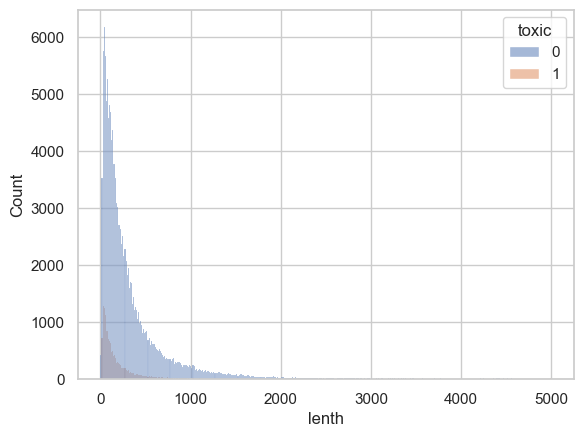

In [15]:
sns.histplot(data=toxic_comments, x='lenth', hue='toxic')

Распределение по комментариям примерно одинаковое, хотя наличие очень больших комментариев выглядит весьма странно

## Модель без BERT

In [16]:
X = toxic_comments['lemm_text']
y = toxic_comments['toxic']
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2,
                                                    random_state=RANDOM_STATE,
                                                   stratify=y)

In [17]:
stopwords = list(nltk_stopwords.words('english'))
count_tf_idf = TfidfVectorizer(stop_words=stopwords)
tf_idf_train = count_tf_idf.fit_transform(X_train)
tf_idf_test = count_tf_idf.transform(X_test)
display(tf_idf_train.shape)
display(tf_idf_test.shape)

(127433, 140606)

(31859, 140606)

In [18]:
pipe = Pipeline(
    [
        ('models', LogisticRegression(random_state=RANDOM_STATE))
    ]
) 

In [19]:
param_grid = [
    {
        'models': [LogisticRegression(random_state=RANDOM_STATE, class_weight='balanced')],
        'models__C': [0.1, 1, 10],
        'models__solver': ['lbfgs', 'liblinear', 'saga']
    },
#     {
#         'models': [SVC(random_state=RANDOM_STATE, class_weight='balanced')],
#         'models__kernel': ['rbf', 'poly']
#     },
#     {
#         'models': [CatBoostClassifier(eval_metric = 'F1', verbose = 20, random_state = RANDOM_STATE)],
#         'models__iterations': [100]
#     }
] 

In [20]:
grid_search = GridSearchCV(
    pipe, 
    param_grid=param_grid,
    cv=5,
    scoring='f1',
    n_jobs=-1,
    verbose=10,
    error_score='raise'
)
grid_search.fit(tf_idf_train, y_train)

Fitting 5 folds for each of 9 candidates, totalling 45 fits


GridSearchCV(cv=5, error_score='raise',
             estimator=Pipeline(steps=[('models',
                                        LogisticRegression(random_state=42))]),
             n_jobs=-1,
             param_grid=[{'models': [LogisticRegression(class_weight='balanced',
                                                        random_state=42)],
                          'models__C': [0.1, 1, 10],
                          'models__solver': ['lbfgs', 'liblinear', 'saga']}],
             scoring='f1', verbose=10)

In [21]:
result = pd.DataFrame(grid_search.cv_results_)
# print(result.columns)
output_result = (result[['mean_fit_time', 'mean_test_score', 'param_models']]
                 .sort_values('mean_test_score', ascending=False))
output_result.head(5)

,mean_fit_time,mean_test_score,param_models
7,6.548813,0.761978,"LogisticRegression(class_weight='balanced', random_state=42)"
6,4.972237,0.761519,"LogisticRegression(class_weight='balanced', random_state=42)"
8,18.679271,0.751713,"LogisticRegression(class_weight='balanced', random_state=42)"
5,21.147738,0.749754,"LogisticRegression(class_weight='balanced', random_state=42)"
4,4.628209,0.747726,"LogisticRegression(class_weight='balanced', random_state=42)"


In [22]:
pred = grid_search.predict(tf_idf_test)
print('f1_score: {:.3f}'.format(f1_score(y_test, pred)))

f1_score: 0.760


Получили необходимый нам результат, но также попробуем моджель с BERT, хотя она и более сложно для компьютера в плане вычислений, из-за чего придется уменьшать выборку

<div class="alert alert-block alert-info">
<b>Совет: </b> Напомню, что внутри кросс-валидации происходит разбиение выборки на треин и валидацию. Однако, в таком случае векторизатор обучен на всей выборке, а это не совсем корректно. Для избежания такого эффекта можно использовать <a href="https://scikit-learn.org/stable/modules/generated/sklearn.pipeline.Pipeline.html">пайплайн</a> из векторизатора и модели. <a href="https://medium.com/analytics-vidhya/ml-pipelines-using-scikit-learn-and-gridsearchcv-fe605a7f9e05">Тут</a> есть пример.
</div>

## Модель c BERT

Сохраним дисбаланс классов на данных, чтобы сравнить работу с TF-IDF, так как там также был дисбаланс. Здесь можно взять равное количество токсичных и не токсичных комментариев, но тогда, на мой взгляд, сравнение моделей будет не совсем верным.

In [23]:
toxic_comments_bert, test = train_test_split(toxic_comments, train_size=1000, test_size=1, random_state=RANDOM_STATE) 
#будет использовано только train, чтобы не писать код для разбиение вручную
toxic_comments_bert.reset_index(inplace=True)
toxic_comments_bert['toxic'].value_counts()

0    893
1    107
Name: toxic, dtype: int64

In [24]:
pretrained_weights = 'bert-base-uncased'
model_bert = transformers.BertModel.from_pretrained(pretrained_weights)
tokenizer_bert = transformers.BertTokenizer.from_pretrained(pretrained_weights)

In [25]:
tokenized = toxic_comments_bert['text'].progress_apply(lambda x: tokenizer_bert.encode(x, add_special_tokens=True))

  0%|          | 0/1000 [00:00<?, ?it/s]

Token indices sequence length is longer than the specified maximum sequence length for this model (876 > 512). Running this sequence through the model will result in indexing errors


В данных найдены слишком большие комментарии, придется их убрать.

In [26]:
X = []
y = []
for i in range(len(tokenized)):
    if len(tokenized[i]) <= 512:
        X.append(tokenized[i])
        y.append(toxic_comments_bert['toxic'][i])
X = pd.Series(X)
y = pd.Series(y)

In [27]:
max_len = 0
for i in X.values:
    if len(i) > max_len:
        max_len = len(i)

padded = np.array([i + [0]*(max_len - len(i)) for i in X.values])

attention_mask = np.where(padded != 0, 1, 0)
max_len

484

In [28]:
batch_size = 50
embeddings = []
for i in notebook.tqdm(range(padded.shape[0] // batch_size)):
        batch = torch.LongTensor(padded[batch_size*i:batch_size*(i+1)]) 
        attention_mask_batch = torch.LongTensor(attention_mask[batch_size*i:batch_size*(i+1)])
        
        with torch.no_grad():
            batch_embeddings = model_bert(batch, attention_mask=attention_mask_batch)
        
        embeddings.append(batch_embeddings[0][:,0,:].numpy())

  0%|          | 0/19 [00:00<?, ?it/s]

In [29]:
features = np.concatenate(embeddings) 
y_cut = y.head(len(features))
X_train, X_test, y_train, y_test = train_test_split(features, y_cut, test_size=0.25,
                                                    random_state=RANDOM_STATE,
                                                    stratify=y_cut)

In [30]:
y_cut.value_counts()

0    849
1    101
dtype: int64

In [31]:
pipe = Pipeline(
    [
        ('models', LogisticRegression(random_state=RANDOM_STATE))
    ]
) 

In [32]:
param_grid = [{
        'models': [LogisticRegression(random_state=RANDOM_STATE, class_weight='balanced', max_iter=500)],
        'models__C': [0.1, 1, 10],
        'models__solver': ['lbfgs', 'liblinear', 'saga']
    },
    {
        'models': [SVC(random_state=RANDOM_STATE, class_weight='balanced')],
        'models__C': [0.1, 1, 10],
        'models__kernel': ['rbf', 'poly', 'sigmoid']
    },
    {
        'models': [RandomForestClassifier(random_state=RANDOM_STATE, class_weight='balanced')],
    },
    {
        'models': [CatBoostClassifier(random_state=RANDOM_STATE)],
        'models__iterations': [100, 200]
    }
] 

In [33]:
grid_search = GridSearchCV(
    pipe, 
    param_grid=param_grid,
    cv=5,
    scoring='f1',
    n_jobs=-1,
    verbose=10,
    error_score='raise'
)
grid_search.fit(X_train, y_train)

Fitting 5 folds for each of 21 candidates, totalling 105 fits


GridSearchCV(cv=5, error_score='raise',
             estimator=Pipeline(steps=[('models',
                                        LogisticRegression(random_state=42))]),
             n_jobs=-1,
             param_grid=[{'models': [LogisticRegression(class_weight='balanced',
                                                        max_iter=500,
                                                        random_state=42)],
                          'models__C': [0.1, 1, 10],
                          'models__solver': ['lbfgs', 'liblinear', 'saga']},
                         {'models': [SVC(class_weight='balanced',
                                         random_state=42)],
                          'models__C': [0.1, 1, 10],
                          'models__kernel': ['rbf', 'poly', 'sigmoid']},
                         {'models': [RandomForestClassifier(class_weight='balanced',
                                                            random_state=42)]},
                         {'models': [<catboost.core.CatBoostClassifier object at 0x0000020E086AA4C0>],
                          'models__iterations': [100, 200]}],
             scoring='f1', verbose=10)

In [34]:
result = pd.DataFrame(grid_search.cv_results_)
# print(result.columns)
output_result = (result[['mean_fit_time', 'mean_test_score', 'param_models']]
                 .sort_values('mean_test_score', ascending=False))
output_result.head(5)

,mean_fit_time,mean_test_score,param_models
3,0.778738,0.675010,"LogisticRegression(class_weight='balanced', max_iter=500, random_state=42)"
0,0.186248,0.671948,"LogisticRegression(class_weight='balanced', max_iter=500, random_state=42)"
8,5.668525,0.670551,"LogisticRegression(class_weight='balanced', max_iter=500, random_state=42)"
2,6.486654,0.667847,"LogisticRegression(class_weight='balanced', max_iter=500, random_state=42)"
1,0.344102,0.667847,"LogisticRegression(class_weight='balanced', max_iter=500, random_state=42)"


In [35]:
pred = grid_search.predict(X_test)
print('f1_score: {:.3f}'.format(f1_score(y_test, pred)))

f1_score: 0.577


По полученным результатам видим, что Bert справился гораздо хуже, мы получили на тестовых данных f1 0.58, что очень мало. Стоит отметить, что было взято 1000 комментариев, так как расчет занимает гораздо больше времени. При большем числе данных результат мог бы стать лучше.

## Выводы

Нами были получены данные от викишоп по комментариям: сами комментарии и определения, токсичный комментарий или нет. Эти данные были обработаны и построены модели для определения токсичности: одна методом TF-IDF, вторая BERT. Для BERT пришлось использовать только часть данных, так как она требует много ресурсов, но на этой части данных эта модель показала результат f1 0.57, что очень плохо, при этом лучшей моделью стала логистическая регрессия на базе TF-IDF. TF-IDF смогла дать результат 0.76 при логистической регрессии, что нас устраивает по критерию задания. Остальные модели строяться слишком долго, поэтому было решено исключить их из кросс-валидации. Таким образом найденная лучшая модель - логистическая регрессия TF-IDF, ее и будем использовать в связи с удовлетворяющей нас метрикой и скоростью работы.

In [36]:
torch.cuda.is_available()

False